In [1]:
import argparse
import os
import sys

from astropy.io import fits

import pint.models as models
import pint.fermi_toas as fermi
import numpy as np
import astropy.units as u
import astropy.constants as const
from astropy.coordinates import SkyCoord

import scipy.optimize as op
import scipy.interpolate as interpolate
import scipy.stats as ss
import matplotlib.pyplot as plt

import pint.fitter as fitter
import pint.toa as toa
# import presto.psr_utils as pu
import pint.derived_quantities as pd
import pint.residuals as pr
import pint.simulation as ps
from pint.utils import FTest
from pint.plot_utils import phaseogram
from pint.eventstats import hmw
from pint.models import parameter as pp

from scipy.linalg import cho_solve,cho_factor,solve_triangular,LinAlgError

import astropy.time
from astropy.time import TimeDelta
from astropy.visualization import quantity_support

import copy
from pint.fitter import MaxiterReached, StepProblem
from pint.utils import FTest

import pint.logging
from loguru import logger as log

pint.logging.setup(level='INFO')

1

In [106]:
# model_kerr, ts_kerr = models.get_model_and_toas('Geminga_kerr.par','Geminga_kerr.tim')
# model_wrn, ts_wrn = models.get_model_and_toas('Geminga_wrn.par','Geminga_wrn.tim')

model_wrn, ts_wrn = models.get_model_and_toas('J2028_wrn.par','J2028_56TOAs.tim')

In [107]:
ts_wrn.compute_pulse_numbers(model_wrn)
# res_kerr = pr.Residuals(ts_kerr,model_kerr)
res_wrn = pr.Residuals(ts_wrn,model_wrn)

In [108]:
def phase_wrap(ts,resids):
    if np.diff(resids).max() > 0.5:
        log.warning('Phase wrap detected')
        for i in range(np.where(np.diff(resids)==np.diff(resids).max())[0][0]+1,len(ts)):
            ts['delta_pulse_number'][i] += -1.0
    return ts

In [109]:
ts_wrn = phase_wrap(ts_wrn, res_wrn.phase_resids)
res_wrn = pr.Residuals(ts_wrn,model_wrn)
phase_resids = np.asarray(res_wrn.phase_resids.astype(np.float64))
time_resids = res_wrn.time_resids.astype(np.float64)

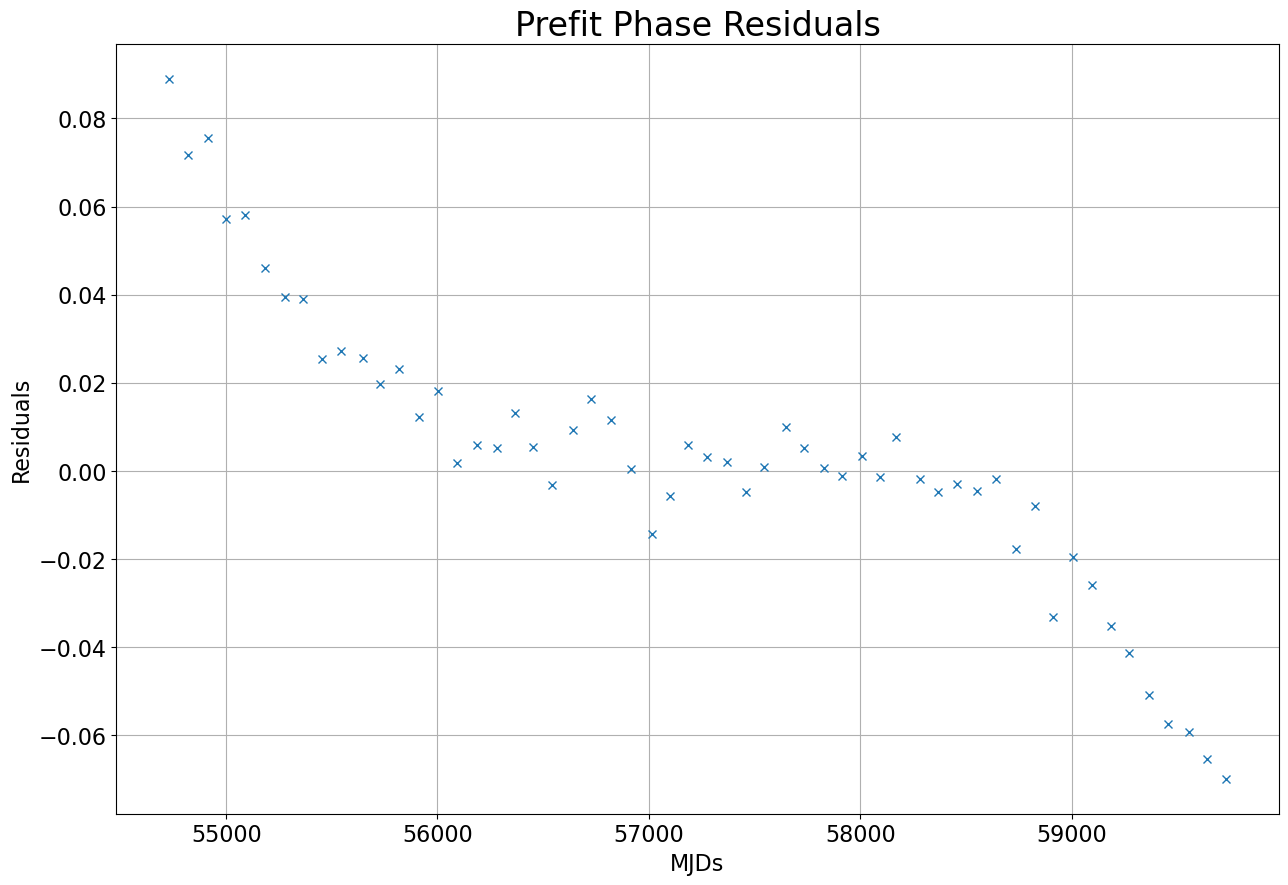

In [110]:
plt.figure(figsize=(15,10))
plt.plot(ts_wrn.get_mjds(),res_wrn.phase_resids,'x')
plt.title('Prefit Phase Residuals', fontsize = 24)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel('Residuals',fontsize = 16)
plt.xlabel('MJDs',fontsize = 16)
plt.grid('True')
plt.show()

In [111]:
nmodes = 10

In [125]:
a = np.fft.fft(res_wrn.time_resids)
# a[0]=0
psd_wrn = np.abs(a)**2
freqs = np.fft.fftfreq(len(psd_wrn),d=1/(2*len(psd_wrn)))

def powlaw(x, a, b) :
    return a * np.power(x, b)
def lin(x,a,b):
    return a*x+b

lim = int(len(psd_wrn)/2)
xdata = freqs[1:nmodes+2]
ydata = psd_wrn[1:nmodes+2]

popt, pcov = op.curve_fit(powlaw,xdata,ydata,maxfev=6000)

amp = 2*np.abs(a[1:nmodes+1])/len(a)
angles = np.angle(a[1:nmodes+1]).value
a_n = np.asarray((np.cos(angles)*amp))
b_n = -np.asarray(np.sin(angles)*amp)

The amplitude is 0.021799106747633357 and the spectral index is -0.7792619065030575


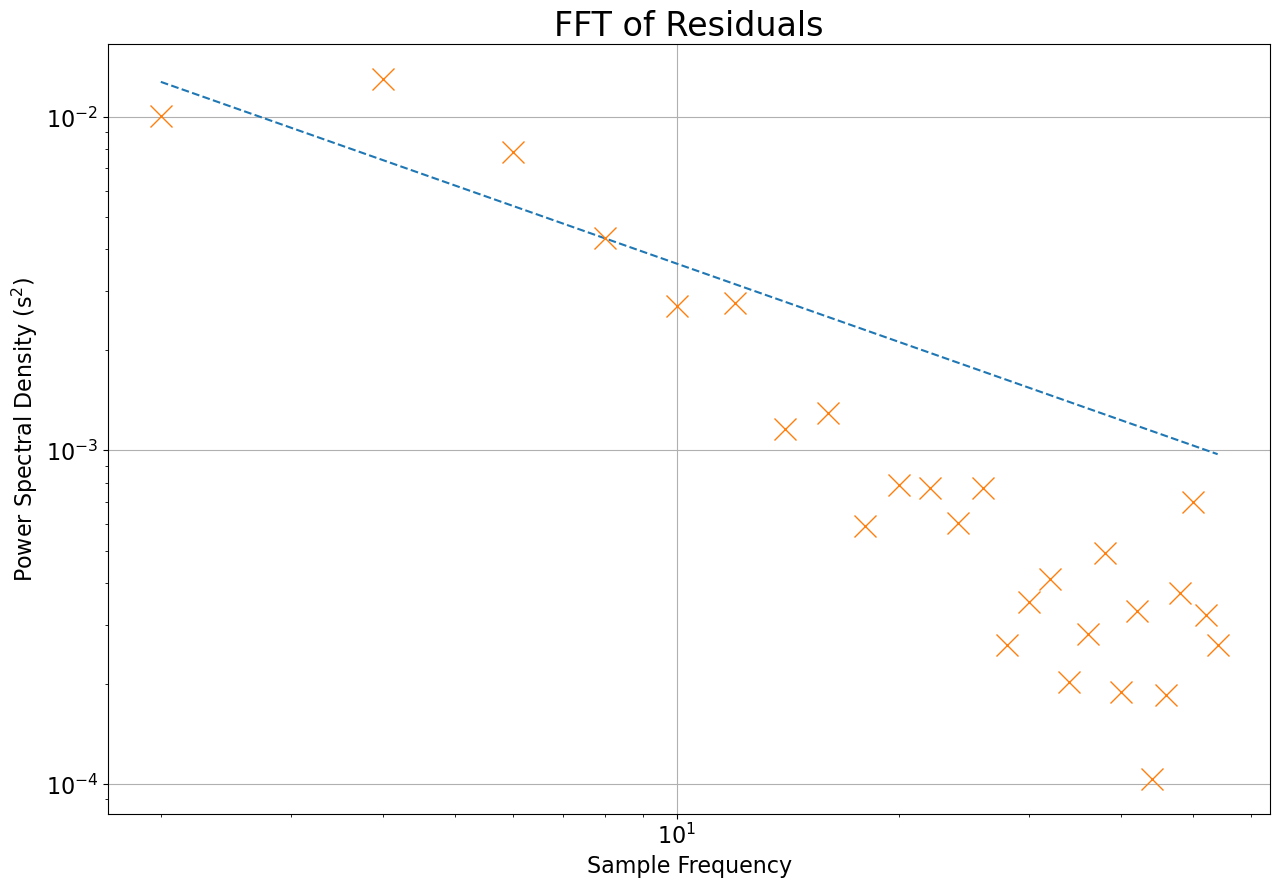

In [126]:
print(f'The amplitude is {popt[0]} and the spectral index is {popt[1]}')
plt.figure(figsize=(15,10))
plt.plot(freqs[1:lim], popt[0]*np.power(freqs[1:lim],popt[1]),'--',markersize=16,label='Power-law Fit')
plt.plot(freqs[1:lim],psd_wrn[1:lim],'x',markersize=16)
plt.title('FFT of Residuals', fontsize = 24)
plt.xscale('log')
plt.yscale('log')
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel('Power Spectral Density (s$^2$)',fontsize = 16)
plt.xlabel('Sample Frequency',fontsize = 16)
plt.grid('True')
plt.show()

In [127]:
# def create_fourier_designmatrix(t, tnscale,a_n,b_n,nmode=50):
    
#     # initialize
#     F = np.zeros((len(t), 2*nmode))
    
#     # phases array
# #     phases = np.ones((len(t),nmode)) * phases[:,np.newaxis]
    
#     mjds = t.get_mjds()
    
#     # set total time
#     T = (mjds[-1] - mjds[0]).to_value(u.yr) # yr
    
#     # fourier spaced frequencies
#     f = np.linspace(1/T, nmode/T, nmode) #inverse yr
    
#     dt = (mjds - mjds[0]).to_value(u.yr) # yr
    
# #     F[:,::2] = np.cos(2*np.pi*t.get_mjds()[:,None].to_value(u.yr)*f[None,:])
# #     F[:,1::2] = np.sin(2*np.pi*t.get_mjds()[:,None].to_value(u.yr)*f[None,:])
# #     F[:,::2] = a_n.T*np.cos(2*np.pi*f[None,:]*dt[:,None])
# #     F[:,1::2] = b_n.T*np.sin(2*np.pi*f[None,:]*dt[:,None])
#     F[:,::2] = np.cos(2*np.pi*f[None,:]*dt[:,None])
#     F[:,1::2] = np.sin(2*np.pi*f[None,:]*dt[:,None])
    
#     F *= tnscale
#     return f, F, T, dt

def designmatrix(mjds,nwaves,setpoint,tnscale):
    ndata = len(mjds)
    Tobs = (mjds[-1]-mjds[0]+2000)/365.25
    freqs = np.linspace(1/Tobs,nwaves/Tobs,nwaves)
    F = np.empty([ndata,2*nwaves],dtype=np.float64)
    phase= np.empty_like(mjds)
    times = (mjds - setpoint)/365.25
    for iharm, freq in enumerate(freqs):
        phase[:] = (2*np.pi*freq)*times
        np.cos(phase,out=F[:,2*iharm])
        np.sin(phase,out=F[:,2*iharm+1])
    F *= tnscale
    return freqs, F, Tobs, times

In [128]:
tobs = (ts_wrn.last_MJD.value - ts_wrn.first_MJD.value+2000)/365.25
tn_scale = (2/tobs)**0.5 * model_wrn.F0.value # Units are wacky
mjds = ts_wrn.get_mjds().value

f, F, T, dt = designmatrix(mjds,nmodes,model_wrn.PEPOCH.value,tn_scale)
# f, F, T, dt = create_fourier_designmatrix(ts_wrn, tn_scale, a_n, b_n, nmode=nmodes)

# phi = create_pl_matrix(popt[0], popt[1], f, T)

# F = F.T
# w = np.random.randn(2*len(f))
# rednoise = np.dot(F,np.sqrt(phi)*w)

rednoise = np.sum(F,axis=1)
coeffs, residuals, _, _ = np.linalg.lstsq(F,phase_resids,rcond=None)
print(f'The residual of the lstsq fit between the Fourier matrix and the simulated rednoise is: {residuals}')
fourier_coeffs = coeffs.reshape(nmodes,2)
cos_coeffs, sin_coeffs = fourier_coeffs[:,::2], fourier_coeffs[:,1::2]
cos_coeffs, sin_coeffs = np.asarray(cos_coeffs.reshape(-1)), np.asarray(sin_coeffs.reshape(-1))

The residual of the lstsq fit between the Fourier matrix and the simulated rednoise is: [0.0013639]


In [129]:
T

19.166752962424752

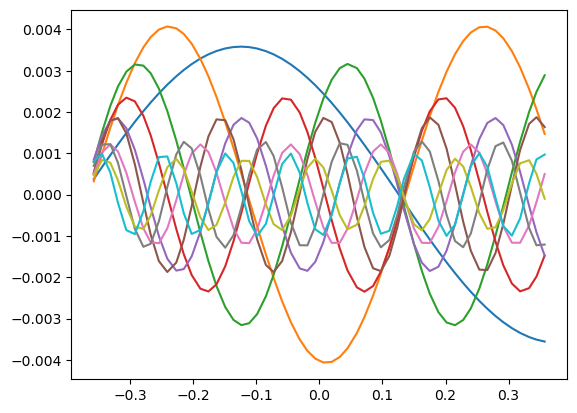

In [130]:
fft_wave = np.zeros(len(dt))

times = (mjds - mjds[0])/365.25
# plt.figure(figsize=(10,5))
# plt.title('Waves using FFT coefficients', fontsize = 24)
# plt.yticks(fontsize=16)
# plt.xticks(fontsize=16)
# plt.ylabel('Amplitude',fontsize = 16)
# plt.xlabel('Phase',fontsize = 16)
# plt.grid('True')
for i in range(nmodes):
    wave = a_n[i]*np.cos(2*np.pi*f[i]*times)+b_n[i]*np.sin(2*np.pi*f[i]*times)
    fft_wave += wave
    plt.plot(dt/T,wave)

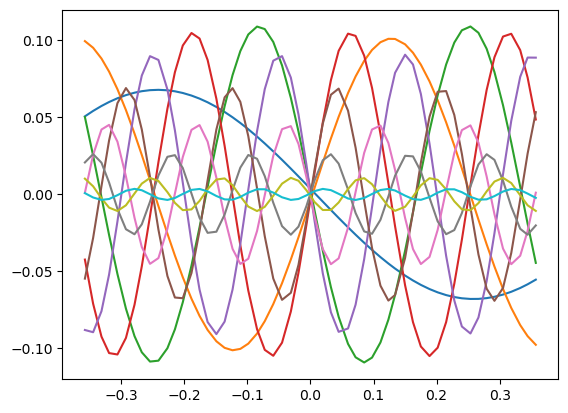

In [131]:
fmat_wave = np.zeros(len(dt))

# plt.figure(figsize=(10,5))
# plt.title('Waves using Fourier Matrix coefficients', fontsize = 24)
# plt.yticks(fontsize=16)
# plt.xticks(fontsize=16)
# plt.ylabel('Amplitude',fontsize = 16)
# plt.xlabel('Phase',fontsize = 16)
# plt.grid('True')
for i in range(nmodes):
    wave = cos_coeffs[i]*np.cos(2*np.pi*f[i]*dt)+sin_coeffs[i]*np.sin(2*np.pi*f[i]*dt)
    fmat_wave += wave
    plt.plot(dt/T,wave)

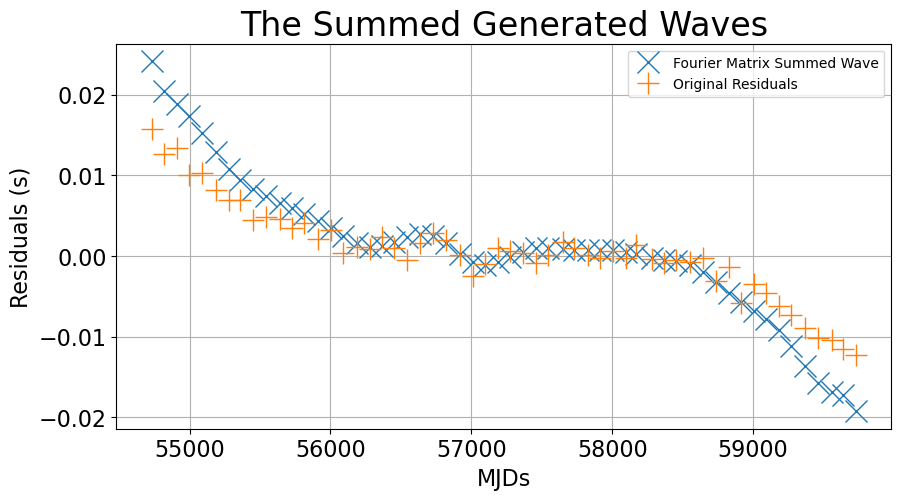

In [132]:
plt.figure(figsize=(10,5))
plt.title('The Summed Generated Waves', fontsize = 24)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel('Residuals (s)',fontsize = 16)
plt.xlabel('MJDs',fontsize = 16)
plt.grid('True')
plt.plot(mjds,fmat_wave/2,'x',markersize = 16,label='Fourier Matrix Summed Wave')
# plt.plot(dt/T, fft_wave, label='FFT Summed Wave')
plt.plot(mjds,time_resids, '+',markersize = 16,label='Original Residuals')
plt.legend()

In [21]:
a_n = -a_n*tn_scale/model_wrn.F0.value
b_n = -b_n*tn_scale/model_wrn.F0.value

model_wrn = models.get_model('J2028_wrn.par')
wave_model = models.wave.Wave()
wave_model.remove_param('WAVE1')
wave_model.WAVE_OM.quantity = 2*np.pi/(ts_wrn.last_MJD-ts_wrn.first_MJD)
wave_model.WAVE_OM.uncertainty = 0.0
wave_model.WAVEEPOCH.quantity = model_wrn.START.quantity
for i in range(nmodes):
#     wave_model.add_param(pp.prefixParameter(name=f'WAVE{i+1}',value=[sin_coeffs[i],cos_coeffs[i]],type_match='pair',parameter_type='pair',long_double=True,units=u.s))
    wave_model.add_param(pp.prefixParameter(name=f'WAVE{i+1}',value=[b_n[i],a_n[i]],type_match='pair',parameter_type='pair',long_double=True,units=u.s))

model_wrn.add_component(wave_model)

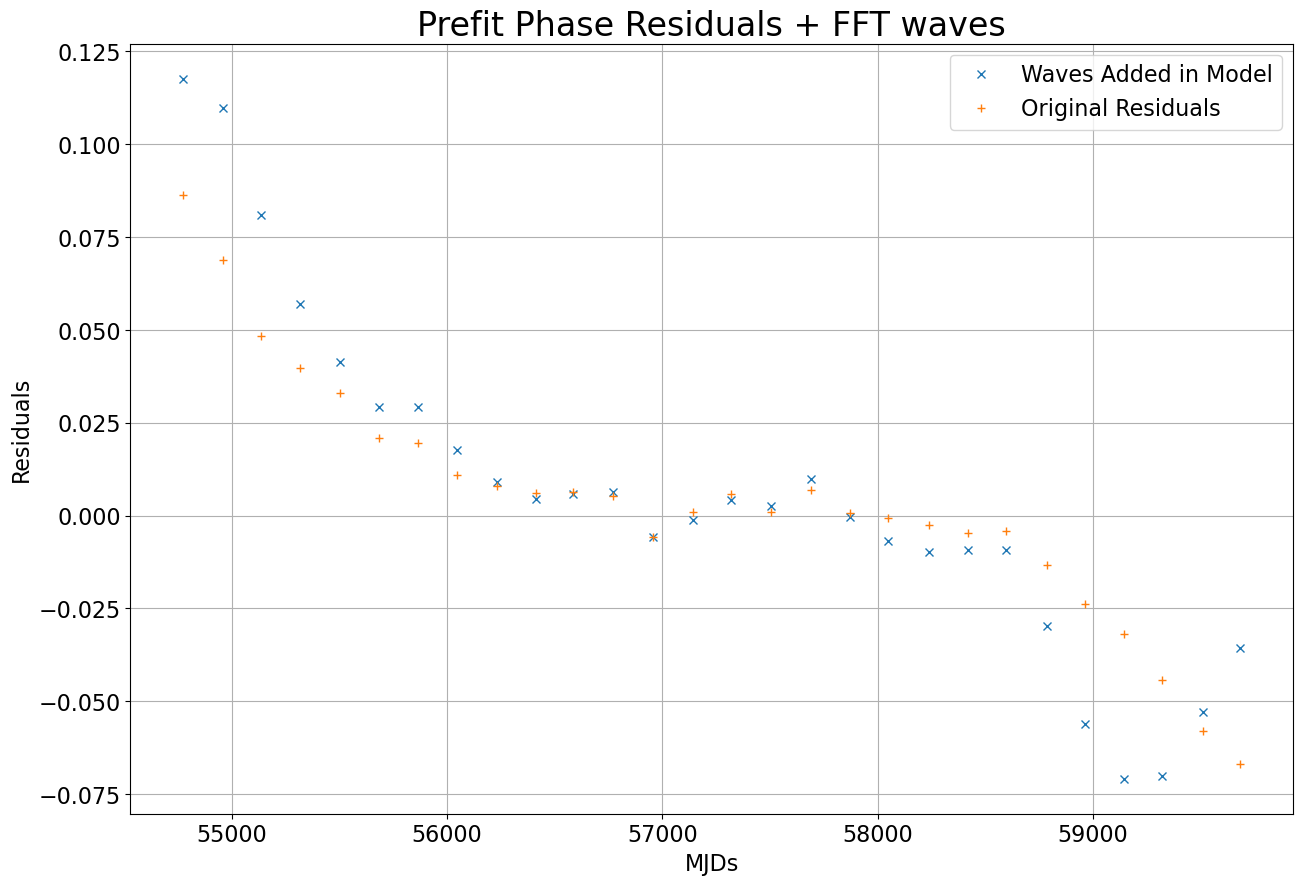

In [22]:
res_wrn = pr.Residuals(ts_wrn,model_wrn)
plt.figure(figsize=(15,10))
plt.plot(ts_wrn.get_mjds(),res_wrn.phase_resids,'x',label='Waves Added in Model')
plt.plot(ts_wrn.get_mjds(),phase_resids,'+',label='Original Residuals')
plt.title('Prefit Phase Residuals + FFT waves', fontsize = 24)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel('Residuals',fontsize = 16)
plt.xlabel('MJDs',fontsize = 16)
plt.grid('True')
plt.legend(fontsize=16)
plt.show()

In [ ]:
f_wrn = fitter.Fitter.auto(ts_wrn,model_wrn)
f_wrn.fit_toas()
f_wrn.plot()

In [133]:
cos_coeffs  = -cos_coeffs*tn_scale/model_wrn.F0.value
sin_coeffs  = -sin_coeffs*tn_scale/model_wrn.F0.value

In [134]:
model_wrn = models.get_model('J2028_wrn.par')
wave_model = models.wave.Wave()
wave_model.remove_param('WAVE1')
wave_model.WAVE_OM.quantity = 2*np.pi/(ts_wrn.last_MJD-ts_wrn.first_MJD+2000*u.d)
wave_model.WAVE_OM.uncertainty = 0.0
wave_model.WAVEEPOCH.quantity = model_wrn.PEPOCH.quantity
for i in range(nmodes):
    wave_model.add_param(pp.prefixParameter(name=f'WAVE{i+1}',value=[sin_coeffs[i],cos_coeffs[i]],type_match='pair',parameter_type='pair',long_double=True,units=u.s))
#     wave_model.add_param(pp.prefixParameter(name=f'WAVE{i+1}',value=[b_n[i],a_n[i]],type_match='pair',parameter_type='pair',long_double=True,units=u.s))

model_wrn.add_component(wave_model)

In [135]:
res_wrn.time_resids

<Quantity [ 1.57299226e-02,  1.26597941e-02,  1.33703443e-02,
            1.00883328e-02,  1.02504423e-02,  8.13475935e-03,
            6.98497880e-03,  6.89827920e-03,  4.51025169e-03,
            4.82175547e-03,  4.54174393e-03,  3.48825938e-03,
            4.09821571e-03,  2.16329431e-03,  3.19009062e-03,
            3.11318662e-04,  1.05859911e-03,  9.19001273e-04,
            2.32090720e-03,  9.81230427e-04, -5.44656485e-04,
            1.64930428e-03,  2.89958217e-03,  2.04025150e-03,
            7.33054219e-05, -2.53669620e-03, -9.86605171e-04,
            1.03795330e-03,  5.68667778e-04,  3.58819013e-04,
           -8.33733114e-04,  1.71716555e-04,  1.76604411e-03,
            9.29070175e-04,  1.24498798e-04, -2.06235659e-04,
            5.93662436e-04, -2.27238169e-04,  1.37806005e-03,
           -3.17006621e-04, -8.30889011e-04, -5.32224421e-04,
           -8.11866741e-04, -3.08253454e-04, -3.13318637e-03,
           -1.39632482e-03, -5.86191016e-03, -3.45011269e-03,
        

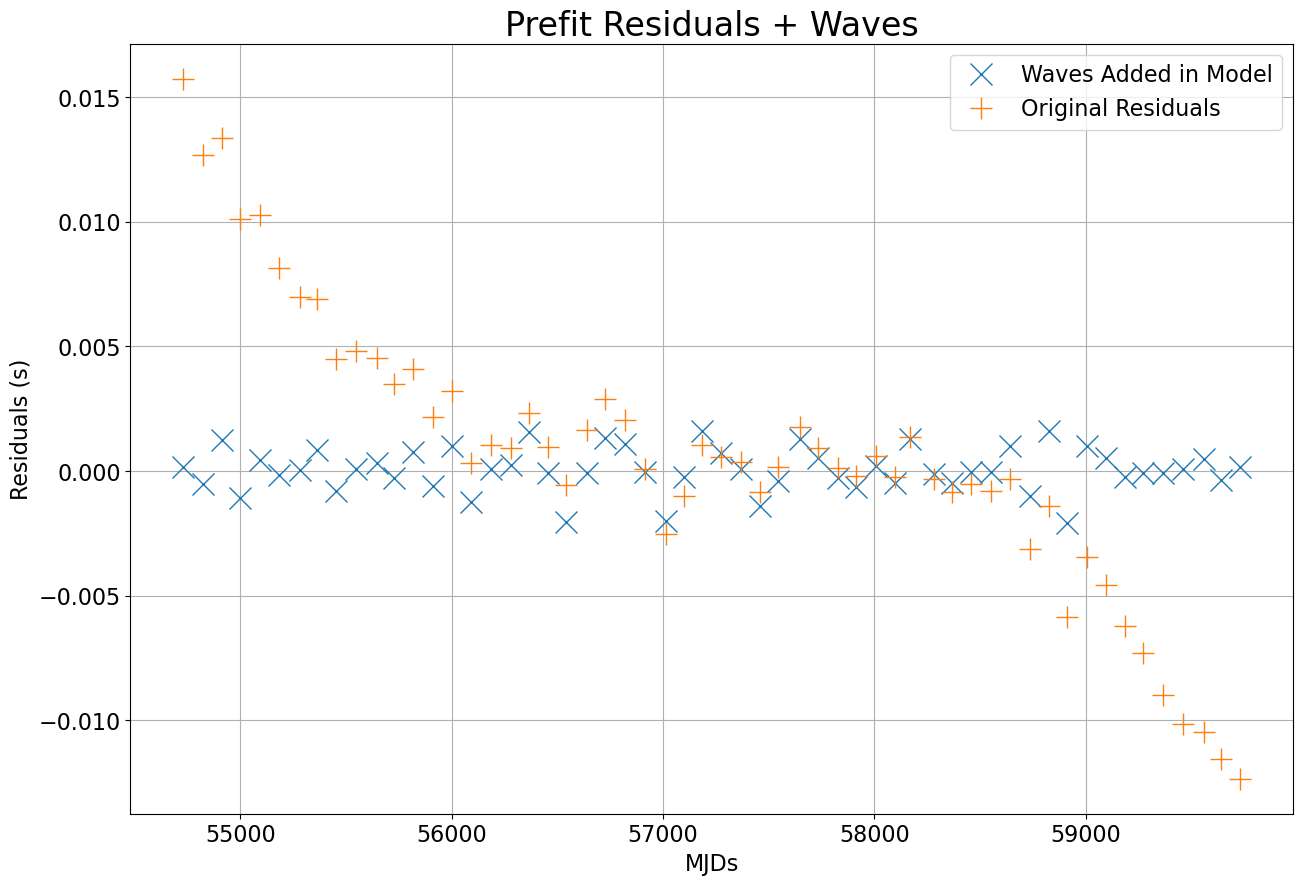

In [136]:
res_wrn = pr.Residuals(ts_wrn,model_wrn)
plt.figure(figsize=(15,10))
plt.plot(ts_wrn.get_mjds(),res_wrn.time_resids,'x',markersize=16,label='Waves Added in Model')
plt.plot(ts_wrn.get_mjds(),time_resids,'+',markersize=16,label='Original Residuals')
plt.title('Prefit Residuals + Waves', fontsize = 24)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel('Residuals (s)',fontsize = 16)
plt.xlabel('MJDs',fontsize = 16)
plt.grid('True')
plt.legend(fontsize=16)
plt.show()

In [ ]:
# f_kerr = fitter.Fitter.auto(ts_kerr,model_kerr,track_mode=None)
f_wrn = fitter.Fitter.auto(ts_wrn,model_wrn)
f_wrn.fit_toas()
f_wrn.plot()

In [ ]:
# def create_pl_matrix(A, gamma, f, numdata):
#     f = np.linspace(f[0],f[-1],numdata//2)
#     # normalization
# #     f1yr = 1 / 3.16e7
    
# #     Pf = A**2 / 12 / np.pi ** 2 * f1yr ** (gamma - 3) * f**(-gamma) / T
#     Pf = A**2 * (f/f[0])**(gamma)
    
#     return np.repeat(Pf, 2)

# phi = create_pl_matrix(popt[0], popt[1], f,len(ts_wrn))

In [ ]:
# coeffs, residuals, _, _ = np.linalg.lstsq(F,np.sqrt(phi),rcond=None)
# print(f'The residual of the lstsq fit between the Fourier matrix and the simulated rednoise is: {residuals}')
# fourier_coeffs = coeffs.reshape(nmodes,2)
# cos_coeffs, sin_coeffs = fourier_coeffs[:,::2], fourier_coeffs[:,1::2]
# cos_coeffs, sin_coeffs = np.asarray(cos_coeffs.reshape(-1)), np.asarray(sin_coeffs.reshape(-1))

In [ ]:
nmodes = 3

In [ ]:
model, ts = models.get_model_and_toas('J2028_wrn.par','J2028_wrn.tim')

In [ ]:
ts.compute_pulse_numbers(model)

In [ ]:
res = pr.Residuals(ts,model)
ts = phase_wrap(ts,res.phase_resids)
phase_res = np.asarray(res.phase_resids.astype(np.float64))

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(ts.get_mjds(),phase_res,'x')
plt.title('Prefit Phase Residuals', fontsize = 24)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel('Residuals',fontsize = 16)
plt.xlabel('MJDs',fontsize = 16)
plt.grid('True')
plt.show()

In [ ]:
# a = np.fft.fft(phase_res)
a = np.fft.fft(np.asarray(res.time_resids.to_value(u.yr).astype(np.float64)))
# a[0]=0
psd = np.abs(a)**2
freqs = np.fft.fftfreq(len(psd),d=100/len(psd))

def powlaw(x, a, b) :
    return a * np.power(x, b)
def lin(x,a,b):
    return a*x+b

lim = int(len(psd)/2)
xdata = freqs[2:nmodes+2]
ydata = psd[2:nmodes+2]

popt_time, pcov_time = op.curve_fit(powlaw,xdata,ydata)

amp = 2*np.abs(a[1:nmodes+1])/len(a)
angles = np.angle(a[1:nmodes+1])
a_n = np.asarray((np.cos(angles)*amp))
b_n = -np.asarray(np.sin(angles)*amp)

print(f'The amplitude is {popt_time[0]} and the spectral index is {popt_time[1]}')
plt.figure(figsize=(15,10))
plt.plot(freqs[1:lim], popt_time[0]*np.power(freqs[1:lim],popt_time[1]),'--',label='Power-law Fit')
plt.plot(freqs[1:lim],psd[1:lim],'x')
plt.title('FFT of Time Residuals', fontsize = 24)
plt.xscale('log')
plt.yscale('log')
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel('Power Spectral Density',fontsize = 16)
plt.xlabel('Sample Frequency',fontsize = 16)
plt.grid('True')

In [ ]:
a = np.fft.fft(phase_res)
# a = np.fft.fft(np.asarray(res.time_resids.to_value(u.yr).astype(np.float64)))
# a[0]=0
psd = np.abs(a)**2
freqs = np.fft.fftfreq(len(psd),d=100/len(psd))

def powlaw(x, a, b) :
    return a * np.power(x, b)
def lin(x,a,b):
    return a*x+b

lim = int(len(psd)/2)
xdata = freqs[2:nmodes+2]
ydata = psd[2:nmodes+2]

popt_phase, pcov_phase = op.curve_fit(powlaw,xdata,ydata)

amp = 2*np.abs(a[1:nmodes+1])/len(a)
angles = np.angle(a[1:nmodes+1])
a_n = np.asarray((np.cos(angles)*amp))
b_n = -np.asarray(np.sin(angles)*amp)

print(f'The amplitude is {popt_phase[0]} and the spectral index is {popt_phase[1]}')
plt.figure(figsize=(15,10))
plt.plot(freqs[1:lim], popt_phase[0]*np.power(freqs[1:lim],popt_phase[1]),'--',label='Power-law Fit')
plt.plot(freqs[1:lim],psd[1:lim],'x')
plt.title('FFT of Phase Residuals', fontsize = 24)
plt.xscale('log')
plt.yscale('log')
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel('Power Spectral Density',fontsize = 16)
plt.xlabel('Sample Frequency',fontsize = 16)
plt.grid('True')
plt.show()

In [ ]:
extended = 2000
# extended = 0
tobs = (ts.last_MJD.value - ts.first_MJD.value+extended)/365.25
tn_scale = (2/tobs)**0.5 * model.F0.value # Units are wacky
mjds = ts.get_mjds().value

In [ ]:
def designmatrix(mjds,nwaves,setpoint,tnscale,extended=0):
#     ndata = len(times2)
    ndata = len(mjds)
    Tobs = (mjds[-1]-mjds[0]+extended)/365.25
    freqs = np.linspace(1/Tobs,nwaves/Tobs,nwaves)
    F = np.empty([ndata,2*nwaves],dtype=np.float64)
    phase= np.empty_like(mjds)
#     phase= np.empty_like(times2)
    times = (mjds - setpoint)/365.25
#     times = (times2-setpoint)/365.25
    for iharm, freq in enumerate(freqs):
        phase[:] = (2*np.pi*freq)*times
        np.cos(phase,out=F[:,2*iharm])
        np.sin(phase,out=F[:,2*iharm+1])
    F *= tnscale
    return freqs, F, Tobs, times

f, F, T, dt = designmatrix(mjds,nmodes,model.PEPOCH.value,tn_scale,extended=extended)

In [ ]:
# coeffs, residuals, _, _ = np.linalg.lstsq(F,res.time_resids.to_value(u.yr).astype(np.float64),rcond=None)
coeffs, residuals, _, _ = np.linalg.lstsq(F,phase_res,rcond=None)
initial_coeffs= coeffs
print(f'The residual of the lstsq fit between the Fourier matrix and the simulated rednoise is: {residuals}')
fourier_coeffs = coeffs.reshape(nmodes,2)
cos_coeffs, sin_coeffs = fourier_coeffs[:,::2], fourier_coeffs[:,1::2]
cos_coeffs, sin_coeffs = np.asarray(cos_coeffs.reshape(-1)), np.asarray(sin_coeffs.reshape(-1))

In [ ]:
# F = F[np.isin(mjds2,mjds)]
# dt = dt[np.isin(mjds2,mjds)]

In [ ]:
# cos_coeffs = -cos_coeffs*tn_scale/model.F0.value
# sin_coeffs= -sin_coeffs*tn_scale/model.F0.value

In [ ]:
fmat_wave = np.zeros(len(dt))

plt.figure(figsize=(10,5))
plt.title('Waves using Fourier Matrix coefficients', fontsize = 24)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel('Amplitude',fontsize = 16)
plt.xlabel('Phase',fontsize = 16)
plt.grid('True')
for i in range(nmodes):
    wave = cos_coeffs[i]*np.cos(2*np.pi*f[i]*dt)+sin_coeffs[i]*np.sin(2*np.pi*f[i]*dt)
    fmat_wave += wave
    plt.plot(dt/T,wave)

In [ ]:
# fft_wave = np.zeros(len(dt))
# times = (mjds - mjds[0])/365.25
# # times = (mjds2-mjds[0])/365.25

# plt.figure(figsize=(10,5))
# plt.title('Waves using Fourier Matrix coefficients', fontsize = 24)
# plt.yticks(fontsize=16)
# plt.xticks(fontsize=16)
# plt.ylabel('Amplitude',fontsize = 16)
# plt.xlabel('Phase',fontsize = 16)
# plt.grid('True')
# for i in range(nmodes):
#     wave = a_n[i]*np.cos(2*np.pi*f[i]*times)+b_n[i]*np.sin(2*np.pi*f[i]*times)
#     fft_wave += wave
#     plt.plot(dt/T,wave)

In [ ]:
# T = (mjds[-1]-mjds[0])/365.25
plt.figure(figsize=(10,5))
plt.title('The Summed Generated Waves', fontsize = 24)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel('Amplitude',fontsize = 16)
plt.xlabel('Phase',fontsize = 16)
plt.grid('True')
plt.plot(dt/T,fmat_wave,'x',label='Fourier Matrix Summed Wave')
# plt.plot(dt/T, fft_wave, 'x',label='FFT Summed Wave')
plt.plot(dt/T,phase_res,'+',label='Residuals')
plt.legend()

In [ ]:
cos_coeffs = -cos_coeffs*tn_scale/model.F0.value
sin_coeffs= -sin_coeffs*tn_scale/model.F0.value

model = models.get_model('J2028_wrn.par')
wave_model = models.wave.Wave()
wave_model.remove_param('WAVE1')
wave_model.WAVE_OM.quantity = 2*np.pi/(ts.last_MJD-ts.first_MJD+extended*u.d)
wave_model.WAVE_OM.uncertainty = 0.0
wave_model.WAVEEPOCH.quantity = model.PEPOCH.quantity
for i in range(nmodes):
    wave_model.add_param(pp.prefixParameter(name=f'WAVE{i+1}',value=[sin_coeffs[i],cos_coeffs[i]],type_match='pair',parameter_type='pair',long_double=True,units=u.s))

model.add_component(wave_model)

# red_model = models.PLRedNoise()
# red_model.add_param(pp.floatParameter(name=f'RNAMP',value=popt[0],frozen=True))
# red_model.add_param(pp.floatParameter(name=f'RNIDX',value=popt[1],frozen=True))
# red_model.add_param(pp.floatParameter(name=f'TNREDAMP',value=np.log10(popt[0]),frozen=True))
# red_model.add_param(pp.floatParameter(name=f'TNREDGAM',value=popt[1],frozen=True))
# red_model.add_param(pp.floatParameter(name=f'TNREDC',value=nmodes,frozen=True))

# model.add_component(red_model)

In [ ]:
res = pr.Residuals(ts,model)
plt.figure(figsize=(15,10))
plt.plot(mjds,res.phase_resids,'x',label='Waves Added in Model')
plt.plot(mjds,phase_res,'+',label='Original Residuals')
plt.title('Prefit Phase Residuals + Design Matrix waves', fontsize = 24)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel('Residuals',fontsize = 16)
plt.xlabel('MJDs',fontsize = 16)
plt.grid('True')
plt.legend(fontsize=16)
plt.show()

In [ ]:
f = fitter.Fitter.auto(ts,model)
f.fit_toas()
f.plot()

In [ ]:
# a_n = -a_n*tn_scale/model.F0.value
# b_n = -b_n*tn_scale/model.F0.value

# model = models.get_model('J2028_wrn.par')
# wave_model = models.wave.Wave()
# wave_model.remove_param('WAVE1')
# wave_model.WAVE_OM.quantity = 2*np.pi/(ts.last_MJD-ts.first_MJD)
# wave_model.WAVE_OM.uncertainty = 0.0
# wave_model.WAVEEPOCH.quantity = model.START.quantity
# for i in range(nmodes):
#     wave_model.add_param(pp.prefixParameter(name=f'WAVE{i+1}',value=[b_n[i],a_n[i]],type_match='pair',parameter_type='pair',long_double=True,units=u.s))

# model.add_component(wave_model)

In [ ]:
# res = pr.Residuals(ts,model)
# plt.figure(figsize=(15,10))
# plt.plot(ts.get_mjds(),res.phase_resids,'x',label='Waves Added in Model')
# plt.plot(ts.get_mjds(),phase_res,'+',label='Original Residuals')
# plt.title('Prefit Phase Residuals + FFT waves', fontsize = 24)
# plt.yticks(fontsize=16)
# plt.xticks(fontsize=16)
# plt.ylabel('Residuals',fontsize = 16)
# plt.xlabel('MJDs',fontsize = 16)
# plt.grid('True')
# plt.legend(fontsize=16)
# plt.show()

In [ ]:
# f = fitter.Fitter.auto(ts,model)
# f.fit_toas()
# f.plot()

In [ ]:
nmodes = 6

In [ ]:
model, ts = models.get_model_and_toas('J2028_wrn.par','J2028_wrn.tim')
# ts = toa.load_pickle('J2028_0.5weight.pickle.gz')
ts.compute_pulse_numbers(model)

In [30]:
def create_pl_matrix(A, gamma, f, T):
    
    # normalization
    f1yr = 1 / 3.16e7
    
#     Pf = A**2 / 12 / np.pi ** 2 * f1yr ** (gamma - 3) * f**(-gamma) / T
    Pf = A**2 * f**(-gamma)
    
    return np.repeat(Pf,2)
#     return Pf


def designmatrix(mjds,nwaves,setpoint,F0,extended=0):
    ndata = len(mjds)
    Tobs = (mjds[-1]-mjds[0]+extended)/365.25
    tnscale = (2/Tobs)**0.5 * F0
    freqs = np.linspace(1/Tobs,nwaves/Tobs,nwaves)
    F = np.empty([ndata,2*nwaves],dtype=np.float64)
    phase= np.empty_like(mjds)
    times = (mjds - setpoint)/365.25
    for iharm, freq in enumerate(freqs):
        phase[:] = (2*np.pi*freq)*times
        np.cos(phase,out=F[:,2*iharm])
        np.sin(phase,out=F[:,2*iharm+1])
    F *= tnscale
    return freqs, F, Tobs, times, tnscale


mjds = ts.get_mjds().value
freqs, F, T, dt, tnscale = designmatrix(mjds,nmodes,model.PEPOCH.value,model.F0.value,extended=extended)

phi = create_pl_matrix(popt_phase[0],-popt_phase[1],freqs,T)

NameError: name 'ts' is not defined

In [31]:
D, params, units = model.designmatrix(ts)
D *= -model.F0.value
D = D.transpose()

output = np.empty((D.shape[0]+F.T.shape[0],D.shape[1]),dtype=np.float64)

NameError: name 'model' is not defined

In [ ]:
output[:D.shape[0]]=D
output[D.shape[0]:]=F.T

In [ ]:
def eval_pl(p,freqs):
    amp,alpha = p
    return (10**amp)*freqs**-alpha

In [ ]:
class TNMatrix(object):
    """ Encapsulate the spectral decomposition form of a TN process."""
    def __init__(self,p,freqs,model,ts,zeropad=None):
        """ NB freqs should be in cycles/year!."""
        self.freqs = freqs
        n = zeropad + 2*len(freqs)
        self._H = np.zeros((n,n),dtype=float)
        x,y = np.diag_indices_from(self._H)
        self._x = x[zeropad:]
        self._y = y[zeropad:]
        self.update_p(p)

        self.model = model
#         self.epoch = model.WAVEEPOCH.value if model.WAVEEPOCH else model.PEPOCH.value
        self.epoch = model.PEPOCH.value
        self.mjds = ts.get_mjds().value
        self.scale = (2/(self.mjds[-1]-self.mjds[0])/365.25)**0.5*self.model.F0.value

    def eval_pl(p,freqs):
        amp,alpha = p
        return (10**amp)*freqs**-alpha

    def update_p(self,p):
        tn_vals = 2./eval_pl(p,self.freqs)
        self._H[self._x[::2],self._y[::2]] = tn_vals
        self._H[self._x[1::2],self._y[1::2]] = tn_vals
        self._p = p

    def get_values(self):
        return self.coeffs
    
    def designmatrix(self,mjds):
        ndata = len(mjds)
        nharm = len(self.freqs)
        F = np.empty([2*nharm,ndata],dtype=np.float128)
        phase = np.empty_like(mjds)
        times = mjds-self.epoch
        for iharm,freq in enumerate(self.freqs):
            phase[:] = (2*np.pi*freq)*times
            np.cos(phase,out=F[2*iharm,:])
            np.sin(phase,out=F[2*iharm+1,:])
        F *= self.scale
        return F
    
    def H(self):
        """ Return inverse covariance matrix."""
        return self._H

In [ ]:
p_p = [np.log10(popt_phase[0]),popt_phase[1]]
p_t = [np.log10(popt_time[0]),popt_time[1]]
M = output
H_tn = TNMatrix(p_p,freqs,model,ts,zeropad=7)

In [ ]:
print(p_p,p_t)

In [ ]:
# tn_phase = np.inner(F,initial_coeffs)
# test_coeffs = np.append(initial_coeffs,np.zeros(6))
test_coeffs = coeffs_Xscale[7:]
tn_phase = np.inner(F,test_coeffs)
# tm_phase = model.phase(ts).frac.value
tm_phase = model.phase(ts,abs_phase=True)
tm_phase = (tm_phase[0]+tm_phase[1]).value

target_phase=ts.get_pulse_numbers()
resid = target_phase-(tn_phase+tm_phase)
# resid=target_phase-tm_phase

In [ ]:
plt.plot(mjds,target_phase-tm_phase,label='Target-TM')
plt.plot(mjds,target_phase-tm_phase-tn_phase,label='Target-TM-TN')
plt.legend()

In [ ]:
H = M@M.T
X = resid@M.T

In [ ]:
# offset=-1
offset=coeffs_Xscale[0]
fitvals = np.append(offset,[getattr(model,p).value for p in model.free_params])
# get_values = np.append(fitvals,initial_coeffs)
# get_values = np.append(fitvals,test_coeffs)
get_values = np.append(fitvals,coeffs_Xscale[7:])

H += H_tn.H()
X -= np.inner(H_tn.H(),get_values) # Applying the power law constraints onto the wave coefficients

In [ ]:
np.inner(H_tn.H(),get_values)

In [ ]:
scale = np.diag(H)**-0.5
Hscale = H*np.outer(scale,scale)
Xscale = X*scale

In [ ]:
try:
    c = cho_factor(Hscale,lower=True)
except LinAlgError:
    print('Inverting initial hessian failed')
    Hscale += np.diag(np.diag(Hscale)*1e-3)
    c = cho_factor(Hscale,lower=True)

In [ ]:
coeffs_Xscale = cho_solve(c,Xscale)*scale

In [ ]:
coeffs_Xscale
# H_tn.H()

In [ ]:
fourier_Xcoeffs = coeffs_Xscale[7:].reshape(nmodes,2)
cos_Xcoeffs, sin_Xcoeffs = fourier_Xcoeffs[:,::2], fourier_Xcoeffs[:,1::2]
cos_Xcoeffs, sin_Xcoeffs = np.asarray(cos_Xcoeffs.reshape(-1)), np.asarray(sin_Xcoeffs.reshape(-1))

In [ ]:
fmat_wave = np.zeros(len(dt))

plt.figure(figsize=(10,5))
plt.title('Waves using Fourier Matrix coefficients', fontsize = 24)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel('Amplitude',fontsize = 16)
plt.xlabel('Phase',fontsize = 16)
plt.grid('True')
for i in range(nmodes):
    wave = cos_Xcoeffs[i]*np.cos(2*np.pi*freqs[i]*dt)+sin_Xcoeffs[i]*np.sin(2*np.pi*freqs[i]*dt)
    fmat_wave += wave
    plt.plot(dt,wave)

In [ ]:
plt.figure(figsize=(10,5))
plt.title('The Summed Generated Waves', fontsize = 24)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel('Amplitude',fontsize = 16)
plt.xlabel('Phase',fontsize = 16)
plt.grid('True')
plt.plot(dt/T,-fmat_wave,'x',label='Fourier Matrix Summed Wave')
# plt.plot(dt/T, fft_wave, 'x',label='FFT Summed Wave')
plt.plot(dt/T,phase_res,'+',label='Residuals')
plt.legend()

In [ ]:
cos_Xcoeffs = cos_Xcoeffs*tn_scale/model.F0.value
sin_Xcoeffs= sin_Xcoeffs*tn_scale/model.F0.value

model = models.get_model('J2028_wrn.par')
wave_model = models.wave.Wave()
wave_model.remove_param('WAVE1')
wave_model.WAVE_OM.quantity = 2*np.pi/(ts.last_MJD-ts.first_MJD+extended*u.d)
wave_model.WAVE_OM.uncertainty = 0.0
wave_model.WAVEEPOCH.quantity = model.PEPOCH.quantity
for i in range(nmodes):
    wave_model.add_param(pp.prefixParameter(name=f'WAVE{i+1}',value=[sin_Xcoeffs[i],cos_Xcoeffs[i]],type_match='pair',parameter_type='pair',long_double=True,units=u.s))

model.add_component(wave_model)

In [ ]:
mjds = ts.get_mjds().value
res = pr.Residuals(ts,model)
plt.figure(figsize=(15,10))
plt.plot(mjds,res.phase_resids,'x',label='Waves Added in Model')
plt.plot(mjds,phase_res,'+',label='Original Residuals')
plt.title('Prefit Phase Residuals + Design Matrix waves', fontsize = 24)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel('Residuals',fontsize = 16)
plt.xlabel('MJDs',fontsize = 16)
plt.grid('True')
plt.legend(fontsize=16)
plt.show()

In [ ]:
f = fitter.Fitter.auto(ts,model)
f.fit_toas()
f.plot()

In [ ]:
def designmatrix(mjds,nwaves,setpoint,F0,extended=0):
    ndata = len(mjds)
    Tobs = (mjds[-1]-mjds[0]+extended)/365.25
    tnscale = (2/Tobs)**0.5 * F0
    freqs = np.linspace(1/Tobs,nwaves/Tobs,nwaves)
    F = np.empty([ndata,2*nwaves],dtype=np.float64)
    phase= np.empty_like(mjds)
    times = (mjds - setpoint)/365.25
    for iharm, freq in enumerate(freqs):
        phase[:] = (2*np.pi*freq)*times
        np.cos(phase,out=F[:,2*iharm])
        np.sin(phase,out=F[:,2*iharm+1])
    F *= tnscale
    return freqs, F, Tobs, times, tnscale

def joint_designmatrix(model,ts,nwaves,extended):
    mjds = ts.get_mjds().value
    
    freqs, F, Tobs, times, tnscale = designmatrix(mjds,nwaves,model.PEPOCH.value,model.F0.value,extended)
    
    D, params, units = model.designmatrix(ts)
    D *= -model.F0.value
    D = D.transpose()

    output = np.empty((D.shape[0]+F.T.shape[0],D.shape[1]),dtype=np.float64)
    output[:D.shape[0]]=D
    output[D.shape[0]:]=F.T
    return output, F, freqs

def update_model(model,coeffs):
    for i,k in enumerate(model.free_params):
        getattr(model,k).value += coeffs[i+1]
    return model
    

def fit_tn_tm_model(model,ts,p,nwaves,niter=2,offset=0.0,eff_wn=0.01,target_phase=0.5,extended=0,coeffs=None,H_tn=None):
    '''
    Do stuff
    '''
    mjds = ts.get_mjds().value # Should be in value of days
        
    red_coeffs = np.ones(2*nwaves,dtype=np.float64)*0.0001 if coeffs is None else coeffs
    
    residuals_post = []
    for i in range(niter):        
        fitvals = np.append(offset,[getattr(model,p).value for p in model.free_params])
        
        # Create timing noise power_law matrix and fourier designmatrix
        n_params = len(fitvals)
        M, F_matrix, freqs = joint_designmatrix(model,ts,nwaves,extended)
        
        # Calculating the residuals
#         tm_phase = model.phase(ts).frac.value
        tm_phase = model.phase(ts,abs_phase=True)
        tm_phase = (tm_phase[0]+tm_phase[1]).value
        tn_phase = np.inner(F_matrix,red_coeffs)
        resid = target_phase-(tn_phase+tm_phase)
        get_values = np.append(fitvals,red_coeffs)
        
        # Linear Algebra time
        if eff_wn is not None:
            Hw = np.diag(np.ones(len(resid))/eff_wn**2)
            T = Hw@M.T
            H = M@T
            X = resid@T
        else:
            H = M@M.T
            X = resid@M.T
        if H_tn is not None:
            H += H_tn.H()
            X -= np.inner(H_tn.H(),get_values)
        
        scale = np.diag(H)**-0.5
        Hscale = H*np.outer(scale,scale)
        Xscale = X*scale
        
        try:
            c = cho_factor(Hscale,lower=True)
        except LinAlgError:
            print('Inverting initial hessian failed')
            Hscale += np.diag(np.diag(Hscale)*1e-3)
            c = cho_factor(Hscale,lower=True)
            
        coeffs = cho_solve(c,Xscale)*scale
        
        # Calculate new residuals to check for improvement
        model = update_model(model,coeffs)
        red_coeffs = coeffs[n_params:]
        freqs, F_matrix, Tobs, dt, tnscale = designmatrix(mjds,nwaves,model.PEPOCH.value,model.F0.value,extended)
        M, F_matrix, freqs = joint_designmatrix(model,ts,nwaves,extended)
#         tm_phase = model.phase(ts).frac.value
        tm_phase = model.phase(ts)
        tm_phase = (tm_phase[0]+tm_phase[1]).value
        tn_phase = np.inner(F_matrix,red_coeffs)
        resid = target_phase-(tn_phase+tm_phase)
        offset -= np.median(resid)
        residuals_post.append(resid)
        
    M, F_matrix, freqs = joint_designmatrix(model,ts,nwaves,extended)
    tm_phase = model.phase(ts)
    tm_phase = (tm_phase[0]+tm_phase[1]).value
    tn_phase = np.inner(F_matrix,red_coeffs)
    resid = target_phase-(tn_phase+tm_phase)
    
    if np.max(np.abs(resid)) > 0.05:
        print(f'The deviation (max = {np.max(np.abs(resid)):.2f}, std = {np.std(np.abs(resid)):.2f}) in phase between the original model and the resulting fit is too large to return a good fit model')
        
    return coeffs, resid, freqs, tnscale, dt, Tobs, residuals_post

def coeffs_to_wave_coeffs(coeffs):
    nmodes = len(coeffs)//2
    wave_coeffs = coeffs.reshape(nmodes,2)
    cos_coeffs, sin_coeffs = wave_coeffs[:,::2], wave_coeffs[:,1::2]
    cos_coeffs, sin_coeffs = np.asarray(cos_coeffs.reshape(-1)), np.asarray(sin_coeffs.reshape(-1))
    return cos_coeffs, sin_coeffs

def plot_waves(coeffs,dt,freqs,Tobs,plot=True,single_waves=False):
    cos_coeffs,sin_coeffs = coeffs_to_wave_coeffs(coeffs)
    fmat_wave = np.zeros(len(dt))
    if plot:
        plt.figure(figsize=(10,5))
        plt.yticks(fontsize=16)
        plt.xticks(fontsize=16)
        plt.ylabel('Amplitude',fontsize = 16)
        plt.xlabel('Phase',fontsize = 16)
        plt.grid('True')
        for i in range(len(cos_coeffs)):
            wave = cos_coeffs[i]*np.cos(2*np.pi*freqs[i]*dt)+sin_coeffs[i]*np.sin(2*np.pi*freqs[i]*dt)
            fmat_wave += wave
            if single_waves:
                plt.title('Waves using Fourier Matrix coefficients', fontsize = 24)
                plt.plot(dt/Tobs,wave)
        if not single_waves:
            plt.title('Summed Wave using Fourier Matrix coefficients', fontsize = 24)
            plt.plot(dt/Tobs,fmat_wave,'+',label='Fourier Matrix Summed Wave')
    return fmat_wave

In [ ]:
p = [np.log10(popt_phase[0]),-popt_phase[1]]
# p = [np.log10(popt_time[0]),-popt_time[1]]
print(p)

In [ ]:
model.designmatrix(ts)

In [ ]:
model, ts = models.get_model_and_toas('J2028_wrn.par','J2028_wrn.tim')
ts.compute_pulse_numbers(model)
n_params = len(model.free_params)+1
H_tn = TNMatrix(p,freqs,model,ts,zeropad=n_params)
target_phase = ts.get_pulse_numbers()
coeffs, residuals, freqs, tnscale, dt, Tobs, residuals_post = fit_tn_tm_model(model,ts,p,nwaves=10,niter=2,target_phase=target_phase,eff_wn=None,extended=2000,coeffs=initial_coeffs,H_tn=H_tn)

In [ ]:
fcoeffs = coeffs[7:]
# print(fcoeffs-initial_coeffs)
fmat_wave = plot_waves(fcoeffs,dt,freqs,Tobs)
plt.plot(dt/T,phase_res,'+',label='Residuals')
plt.legend()

In [ ]:
for i in range(len(residuals_post)):
    plt.plot(residuals_post[i],label=f'Residuals {i}')
    plt.legend()

In [ ]:
fourier_Xcoeffs = coeffs[7:].reshape(nmodes,2)
cos_Xcoeffs, sin_Xcoeffs = fourier_Xcoeffs[:,::2], fourier_Xcoeffs[:,1::2]
cos_Xcoeffs, sin_Xcoeffs = np.asarray(cos_Xcoeffs.reshape(-1)), np.asarray(sin_Xcoeffs.reshape(-1))

cos_Xcoeffs = cos_Xcoeffs*tn_scale/model.F0.value
sin_Xcoeffs = sin_Xcoeffs*tn_scale/model.F0.value

model = models.get_model('J2028_wrn.par')
wave_model = models.wave.Wave()
wave_model.remove_param('WAVE1')
wave_model.WAVE_OM.quantity = 2*np.pi/(ts.last_MJD-ts.first_MJD+2000*u.d)
wave_model.WAVE_OM.uncertainty = 0.0
wave_model.WAVEEPOCH.quantity = model.PEPOCH.quantity
for i in range(nmodes):
    wave_model.add_param(pp.prefixParameter(name=f'WAVE{i+1}',value=[-sin_Xcoeffs[i],-cos_Xcoeffs[i]],type_match='pair',parameter_type='pair',long_double=True,units=u.s))

model.add_component(wave_model)

mjds = ts.get_mjds().value
res = pr.Residuals(ts,model)
plt.figure(figsize=(15,10))
plt.plot(mjds,res.phase_resids,'x',label='Waves Added in Model')
plt.plot(mjds,phase_res,'+',label='Original Residuals')
plt.title('Prefit Phase Residuals + Design Matrix waves', fontsize = 24)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel('Residuals',fontsize = 16)
plt.xlabel('MJDs',fontsize = 16)
plt.grid('True')
plt.legend(fontsize=16)
plt.show()

In [ ]:
print(params)
print(coeffs[:7])
print('Wave coefficients\n',coeffs[7:])

In [ ]:
# Removing the effective white noise estimate in the fit function
model, ts = models.get_model_and_toas('J2028_wrn.par','J2028_wrn.tim')
ts.compute_pulse_numbers(model)
n_params = len(model.free_params)+1
H_tn = TNMatrix(p,freqs,model,ts,zeropad=n_params)
target_phase = ts.get_pulse_numbers()
coeffs, residuals, freqs, tnscale, dt, Tobs, residuals_post = fit_tn_tm_model(model,ts,p,nwaves=10,niter=2,target_phase=target_phase,eff_wn=None,extended=2000,coeffs=initial_coeffs,H_tn=H_tn)

In [ ]:
fcoeffs = coeffs[7:]
fmat_wave = plot_waves(fcoeffs,dt,freqs,Tobs)
plt.plot(dt/T,phase_res,'+',label='Residuals')
plt.legend()

In [ ]:
for i in range(len(residuals_post)):
    plt.plot(residuals_post[i],label=f'Residuals {i}')
    plt.legend()

In [ ]:
fourier_Xcoeffs = coeffs[7:].reshape(nmodes,2)
cos_Xcoeffs, sin_Xcoeffs = fourier_Xcoeffs[:,::2], fourier_Xcoeffs[:,1::2]
cos_Xcoeffs, sin_Xcoeffs = np.asarray(cos_Xcoeffs.reshape(-1)), np.asarray(sin_Xcoeffs.reshape(-1))

cos_Xcoeffs = cos_Xcoeffs*tn_scale/model.F0.value
sin_Xcoeffs = sin_Xcoeffs*tn_scale/model.F0.value

model = models.get_model('J2028_wrn.par')
wave_model = models.wave.Wave()
wave_model.remove_param('WAVE1')
wave_model.WAVE_OM.quantity = 2*np.pi/(ts.last_MJD-ts.first_MJD+2000*u.d)
wave_model.WAVE_OM.uncertainty = 0.0
wave_model.WAVEEPOCH.quantity = model.PEPOCH.quantity
for i in range(nmodes):
    wave_model.add_param(pp.prefixParameter(name=f'WAVE{i+1}',value=[-sin_Xcoeffs[i],-cos_Xcoeffs[i]],type_match='pair',parameter_type='pair',long_double=True,units=u.s))

model.add_component(wave_model)

mjds = ts.get_mjds().value
res = pr.Residuals(ts,model)
plt.figure(figsize=(15,10))
plt.plot(mjds,res.phase_resids,'x',label='Waves Added in Model')
plt.plot(mjds,phase_res,'+',label='Original Residuals')
plt.title('Prefit Phase Residuals + Design Matrix waves', fontsize = 24)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel('Residuals',fontsize = 16)
plt.xlabel('MJDs',fontsize = 16)
plt.grid('True')
plt.legend(fontsize=16)
plt.show()

In [ ]:
params

In [ ]:
coeffs[:7]

In [ ]:
fake_coeffs = np.random.uniform(-1,1,(20,))*0.01
fake_coeffs

In [ ]:
# Fake coefficients
model, ts = models.get_model_and_toas('J2028_wrn.par','J2028_wrn.tim')
ts.compute_pulse_numbers(model)
n_params = len(model.free_params)+1
H_tn = TNMatrix(p,freqs,model,ts,zeropad=n_params)
target_phase = ts.get_pulse_numbers()
coeffs, residuals, freqs, tnscale, dt, Tobs, residuals_post = fit_tn_tm_model(model,ts,p,nwaves=10,niter=2,target_phase=target_phase,eff_wn=0.01,extended=2000)#,coeffs=fake_coeffs,H_tn=H_tn)

In [ ]:
fcoeffs = coeffs[7:]
fmat_wave = plot_waves(fcoeffs,dt,freqs,Tobs)
plt.plot(dt/T,phase_res,'+',label='Residuals')
plt.legend()

In [ ]:
for i in range(len(residuals_post)):
    plt.plot(residuals_post[i],label=f'Residuals {i}')
    plt.legend()

In [ ]:
fourier_Xcoeffs = coeffs[7:].reshape(nmodes,2)
cos_Xcoeffs, sin_Xcoeffs = fourier_Xcoeffs[:,::2], fourier_Xcoeffs[:,1::2]
cos_Xcoeffs, sin_Xcoeffs = np.asarray(cos_Xcoeffs.reshape(-1)), np.asarray(sin_Xcoeffs.reshape(-1))

cos_Xcoeffs = cos_Xcoeffs*tn_scale/model.F0.value
sin_Xcoeffs = sin_Xcoeffs*tn_scale/model.F0.value

model = models.get_model('J2028_wrn.par')
wave_model = models.wave.Wave()
wave_model.remove_param('WAVE1')
wave_model.WAVE_OM.quantity = 2*np.pi/(ts.last_MJD-ts.first_MJD+2000*u.d)
wave_model.WAVE_OM.uncertainty = 0.0
wave_model.WAVEEPOCH.quantity = model.PEPOCH.quantity
for i in range(nmodes):
    wave_model.add_param(pp.prefixParameter(name=f'WAVE{i+1}',value=[-sin_Xcoeffs[i],-cos_Xcoeffs[i]],type_match='pair',parameter_type='pair',long_double=True,units=u.s))

model.add_component(wave_model)

mjds = ts.get_mjds().value
res = pr.Residuals(ts,model)
plt.figure(figsize=(15,10))
plt.plot(mjds,res.phase_resids,'x',label='Waves Added in Model')
plt.plot(mjds,phase_res,'+',label='Original Residuals')
plt.title('Prefit Phase Residuals + Design Matrix waves', fontsize = 24)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel('Residuals',fontsize = 16)
plt.xlabel('MJDs',fontsize = 16)
plt.grid('True')
plt.legend(fontsize=16)
plt.show()

In [ ]:
initial_coeffs

In [ ]:
# WaveX
model, ts = models.get_model_and_toas('Geminga_wrn.par', 'Geminga_wrn.tim')
ts.compute_pulse_numbers(model)
mjds = ts.get_mjds()
residuals = pr.Residuals(ts,model)
ts = phase_wrap(ts,residuals.phase_resids)
residuals = pr.Residuals(ts,model)

In [ ]:
tspan = mjds[-1]-mjds[0]
freqs = np.arange(1,60)/tspan
indices = np.arange(1,60)
model.add_component(models.WaveX())
model.WXFREQ_0001.value = freqs[0]
model.components['WaveX'].add_wavex_components(freqs[1:],indices[1:],frozens=False)

In [ ]:
f = fitter.Fitter.auto(ts,model)
f.fit_toas()
f.plot()

In [ ]:
f.print_summary()

In [ ]:
def wave_fitter(model,ts,nwaves=1,show_plot=False):
    '''
    Does a iterative fit of a no red noise model adding waves with each iteration and compares the fitted model with the previous iteration using the F-test
    '''
    fresh_fit = False
    ts.compute_pulse_numbers(model)
    mjds = ts.get_mjds()
    residuals = pr.Residuals(ts,model)
    ts = phase_wrap(ts,residuals.phase_resids)
    residuals = pr.Residuals(ts,model)
    PM_values = []
    PM_values.append([0,model.PMRA.value,model.PMRA.uncertainty_value,model.PMDEC.value,model.PMDEC.uncertainty_value])
#     PM_values.append([0,model.PMELONG.value,model.PMELONG.uncertainty_value,model.PMELAT.value,model.PMELAT.uncertainty_value])
    if show_plot:
        quantity_support()
        plt.figure(figsize=(16,9))
        plt.yticks(fontsize=16)
        plt.xticks(fontsize=16)
        plt.ylabel('Residuals',fontsize = 16)
        plt.xlabel('MJDs',fontsize = 16)
        plt.errorbar(mjds,residuals.time_resids,yerr=ts.get_errors(),fmt='+')
        plt.title('Initial Residuals',fontsize=20)
        plt.grid()
        plt.show()
    tspan = mjds[-1]-mjds[0]
    for i in range(1,nwaves+1):
        log.info(f'Fitting {i} waves')
        # Setting up the waves within the model
        if i == 1:
            fit_model = copy.deepcopy(model)
            freq = 1/tspan
            fit_model.add_component(models.WaveX())
            fit_model.WXFREQ_0001.value = freq
        else:
            fit_model = copy.deepcopy(red_fitter.model)
            freq = i/tspan
            fit_model.components['WaveX'].add_wavex_component(freq,i,frozen=False)
        # Running the fitter
        try:
            red_fitter = fitter.Fitter.auto(ts,fit_model)
            red_fitter.fit_toas()
            red_fitter.update_model()
            red_fitter.model.CHI2.value = red_fitter.resids.chi2
            PM_values.append([i,red_fitter.model.PMRA.value,red_fitter.model.PMRA.uncertainty_value,red_fitter.model.PMDEC.value,red_fitter.model.PMDEC.uncertainty_value])   
#             PM_values.append([i,red_fitter.model.PMELONG.value,red_fitter.model.PMELONG.uncertainty_value,red_fitter.model.PMELAT.value,red_fitter.model.PMELAT.uncertainty_value])   
            if show_plot:
                red_fitter.plot()
        except (MaxiterReached, StepProblem) as e:
            log.warning(f'{e} encountered when fitting {i} waves')
            continue
            
        # Stop criteria
        if red_fitter.resids_init.rms_weighted()/red_fitter.resids.rms_weighted() % 1 < 0.01:
            log.warning(f'The ratio of pre-fit and post-fit rms is less than 3.0 at {i} waves')
            break        
#         if np.mean(red_fitter.resids.time_resids)/np.mean(red_fitter.resids_init.time_resids) % 1 < 0.01:
#             log.warning(f'The change is time residuals is less than 1%')
#             break
        # F-test check
        # dof_1 = (red_fitter.model_init.NTOA.value - len(red_fitter.model_init.free_params) + 1 - 1 ) # The - 1 is to remove for the added wave parameter
        # log.info(f'Initial Model: CHI2 {red_fitter.model_init.CHI2.value}, DOF: {dof_1}')
        # log.info(f'Postfit Model: CHI2 {red_fitter.resids.chi2}, DOF: {red_fitter.resids.dof}')
        # ftest = FTest(red_fitter.model_init.CHI2.value,dof_1, red_fitter.resids.chi2,red_fitter.resids.dof)
        # log.info(f'The F-test value between {i} and {i-1} waves is : {ftest}')
        
    return residuals, red_fitter, PM_values

def iterative_wave_fitter(model,ts,nwaves=1,show_plot=False):
    '''
    Does a iterative fit of a no red noise model adding waves with each iteration and compares the fitted model with the previous iteration using the F-test
    '''
    fresh_fit = False
    ts.compute_pulse_numbers(model)
    mjds = ts.get_mjds()
    residuals = pr.Residuals(ts,model)
    ts = phase_wrap(ts,residuals.phase_resids)
    residuals = pr.Residuals(ts,model)
    PM_values = []
#     PM_values.append([0,model.PMRA.value,model.PMRA.uncertainty_value,model.PMDEC.value,model.PMDEC.uncertainty_value])
    PM_values.append([0,model.PMELONG.value,model.PMELONG.uncertainty_value,model.PMELAT.value,model.PMELAT.uncertainty_value])
    if show_plot:
        quantity_support()
        plt.figure(figsize=(16,9))
        plt.yticks(fontsize=16)
        plt.xticks(fontsize=16)
        plt.ylabel('Residuals',fontsize = 16)
        plt.xlabel('MJDs',fontsize = 16)
        plt.errorbar(mjds,residuals.time_resids,yerr=ts.get_errors(),fmt='+')
        plt.title('Initial Residuals',fontsize=20)
        plt.grid()
        plt.show()
    tspan = mjds[-1]-mjds[0]
    try:
        model.components['WaveX']
    except KeyError:
        log.info(f'Model does not have any red noise components, Starting a fresh fit')
        fresh_fit=True
    if fresh_fit:
        for i in range(1,nwaves+1):
            log.info(f'Fitting {i} waves')
            # Setting up the waves within the model
            if i == 1:
                fit_model = copy.deepcopy(model)
                freq = 1/tspan
                fit_model.add_component(models.WaveX())
                fit_model.WXFREQ_0001.value = freq
            else:
                fit_model = copy.deepcopy(red_fitter.model)
                freq = i/tspan
                fit_model.components['WaveX'].add_wavex_component(freq,i,frozen=False)
            # Running the fitter
            try:
                red_fitter = fitter.Fitter.auto(ts,fit_model)
                red_fitter.fit_toas()
                red_fitter.update_model()
                red_fitter.model.CHI2.value = red_fitter.resids.chi2
#                 PM_values.append([i,red_fitter.model.PMRA.value,red_fitter.model.PMRA.uncertainty_value,red_fitter.model.PMDEC.value,red_fitter.model.PMDEC.uncertainty_value])   
                PM_values.append([i,red_fitter.model.PMELONG.value,red_fitter.model.PMELONG.uncertainty_value,red_fitter.model.PMELAT.value,red_fitter.model.PMELAT.uncertainty_value])   
                if show_plot:
                    red_fitter.plot()
            except (MaxiterReached, StepProblem) as e:
                log.warning(f'{e} encountered when fitting {i} waves')
                continue
    else:
        last_index = model.components['WaveX'].get_indices()[-1]
        fit_model = copy.deepcopy(model)
        if last_index >= nwaves:
            log.warning(f'The number of waves within the model is larger than the number of waves to be added')
        for i in range(last_index+1,nwaves+1):
            log.info(f'Fitting {i} waves')
            freq = i/tspan
            fit_model.components['WaveX'].add_wavex_component(freq,i,frozen=False)
            red_fitter = fitter.Fitter.auto(ts,fit_model)
            try:
                red_fitter.fit_toas()
            except (MaxiterReached, StepProblem) as e:
                log.warning(f'{e} encountered when fitting {i} waves')
                continue
            red_fitter.update_model()
            red_fitter.model.CHI2.value = red_fitter.resids.chi2
            fit_model = copy.deepcopy(red_fitter.model)
            
        # Stop criteria
#         if np.mean(red_fitter.resids.time_resids)/np.mean(red_fitter.resids_init.time_resids) % 1 < 0.01:
#             log.warning(f'The change is time residuals is less than 1%')
#             break
        # F-test check
        # dof_1 = (red_fitter.model_init.NTOA.value - len(red_fitter.model_init.free_params) + 1 - 1 ) # The - 1 is to remove for the added wave parameter
        # log.info(f'Initial Model: CHI2 {red_fitter.model_init.CHI2.value}, DOF: {dof_1}')
        # log.info(f'Postfit Model: CHI2 {red_fitter.resids.chi2}, DOF: {red_fitter.resids.dof}')
        # ftest = FTest(red_fitter.model_init.CHI2.value,dof_1, red_fitter.resids.chi2,red_fitter.resids.dof)
        # log.info(f'The F-test value between {i} and {i-1} waves is : {ftest}')
        
    return residuals, red_fitter, PM_values

In [ ]:
f.model.components['WaveX'].get_indices()[-1]

In [ ]:
test_residuals = pr.Residuals(ts,model)
# plt.plot(test_residuals.phase_resids,'+')
plt.plot(test_residuals.time_resids,'+')


In [ ]:
model, ts = models.get_model_and_toas('Geminga_wrn.par', 'Geminga_wrn.tim')
# ts.compute_pulse_numbers(model)
# test_residuals = pr.Residuals(ts,model)
# ts = phase_wrap(ts,test_residuals.phase_resids)
# test_residuals = pr.Residuals(ts,model)
# ts = ts[test_residuals.time_resids < (test_residuals.time_resids.std()*5)]
# for i in model.free_params:
#     if not i.startswith('F'):
#         model[i].frozen=True
# model.PMRA.value = 0
# model.PMDEC.value = 0
initial_resids, f, PM_values = wave_fitter(model,ts,nwaves=7)

In [ ]:
print(f'Number of Waves,   PMRA,   PMRA_error,   PMDEC,    PMDEC_error')
for i in range(len(PM_values)):
    print(PM_values[i])

In [ ]:
f.resids.rms_weighted()/f.resids_init.rms_weighted()

In [ ]:
ts = toa.get_TOAs('Geminga_wrn.tim')
ts.compute_pulse_numbers(f.model)
test_residuals = pr.Residuals(ts,f.model)
phase_wrap(ts,test_residuals.phase_resids)
f = fitter.Fitter.auto(ts,f.model)
f.fit_toas()
f.plot()

In [ ]:
plt.plot(f.resids_init.phase_resids,'+')

In [ ]:
model, ts = models.get_model_and_toas('J2028_wrn.par', 'J2028_wrn.tim')
initial_resids, f = wave_fitter(model,ts,nwaves=3,show_plot=True)

In [32]:
# Trying with freezing the timing models and only fitting red noise
model,ts = models.get_model_and_toas('J2028_wrn.par','J2028_wrn.tim')
# for i in model.free_params:
#     if not i.startswith('F'):
#         model[i].frozen=True
# initial_resids, f, PM_values = wave_fitter(model,ts,nwaves=13,show_plot=True)

In [ ]:
numwaves = np.arange(0,len(PM_values))
for i in range(len(numwaves)):
    plt.errorbar(numwaves[i],PM_values[:][i][1],yerr=PM_values[:][i][2],fmt='+')
plt.xlabel('Number of Waves')
plt.ylabel('Proper Motion (mas/yr)')
plt.title('Proper Motion RA vs. Number of Waves')

In [ ]:
numwaves = np.arange(0,len(PM_values))
for i in range(len(numwaves)):
    plt.errorbar(numwaves[i],PM_values[:][i][3],yerr=PM_values[:][i][4],fmt='+')
plt.xlabel('Number of Waves')
plt.ylabel('Proper Motion (mas/yr)')
plt.title('Proper Motion DEC vs. Number of Waves')

In [34]:
import copy
model2 = copy.deepcopy(model)
phot_ts = toa.load_pickle('J2028_0.5weight.pickle.gz')

In [35]:
from pint.scripts import event_optimize as eo
gauss_file = '2028.gaussians'
gtemplate = eo.read_gaussfitfile(gauss_file,proflen=256)
gtemplate /= gtemplate.mean()

In [36]:
weights = np.asarray([float(x['weight']) for x in phot_ts.table['flags']])

In [37]:
phot_fitter_nowaves = eo.emcee_fitter(phot_ts, model,gtemplate, weights)
phot_fitter_waves = eo.emcee_fitter(phot_ts, model2, gtemplate, weights)

In [40]:
phot_ts.get_errors()

<Quantity [1., 1., 1., ..., 1., 1., 1.] us>

In [ ]:
fitvals = phot_fitter_nowaves.fitvals

In [ ]:
phases = phot_fitter_nowaves.get_event_phases()
binned_counts, binned_phases  = np.histogram(phases,bins=64)
binned_phases = binned_phases[:-1]

In [ ]:
phot_ts.compute_pulse_numbers(model)
full_phases = model.phase(phot_ts)
full_phases = full_phases[0]+full_phases[1]
phot_resids = phot_ts.get_pulse_numbers()-full_phases
plt.plot(phot_resids,'+')
# plt.plot(phases,'*')

In [ ]:
# plt.hist(phases,bins=64)
max_pulse = binned_phases[binned_counts == binned_counts.max()]
phot_resids = phases - max_pulse

In [ ]:
# plt.hist(phot_resids,bins=64)
plt.hist(phases,bins=64)

In [ ]:
from pint.scripts.event_optimize import profile_likelihood

In [ ]:
xtemp = np.arange(len(gtemplate))*1.0/len(gtemplate)
phs = 0.4
lnlikelihood = profile_likelihood(phs,xtemp,phases,gtemplate,weights)

In [ ]:
lnlikelihood

In [ ]:
wn_level = 1/(np.sqrt(-lnlikelihood)*model.F0.value)
wn_level
# Generate fake toas with zero residuals and then add in gaussian noise. Calculate the log likelihood
# and see if the wn_level matches what we expect from the gaussian

In [ ]:
model, ts = models.get_model_and_toas('J0633+0632_wrn.par', 'J0633+0632_wrn.tim')
# initial_resids, f, PM_values, PM_errs = wave_fitter(model,ts[mjds <57750],nwaves=5,show_plot=True)

In [ ]:
model.get_prefix_mapping('WX')

In [ ]:
mjds = ts.get_mjds().value
x = np.arange(57500,60000,200)

In [ ]:
model2 = copy.deepcopy(model)
nwaves = 20
show_plot=False
for i in x:
    log.info(f'Fitting {ts[mjds < i]}')
    initial_resids, f, PM_values = iterative_wave_fitter(model2,ts[mjds < i],nwaves=nwaves,show_plot=show_plot)
    show_plot=True
    model2 = copy.deepcopy(f.model)
    nwaves += 1

In [ ]:
plt.plot(iter_fitter.resids_init.phase_resids,'x')
plt.plot(iter_fitter.resids.phase_resids,'+')

In [ ]:
numwaves = np.arange(0,len(PM_values))
for i in range(len(numwaves)):
    plt.errorbar(numwaves[i],PM_values[:][i][1],yerr=PM_values[:][i][2],fmt='+')
plt.xlabel('Number of Waves')
plt.ylabel('Proper Motion (mas/yr)')
plt.title('Proper Motion RA vs. Number of Waves')

In [ ]:
for i in range(len(numwaves)):
    plt.errorbar(numwaves[i],PM_values[:][i][3],yerr=PM_values[:][i][4],fmt='+')
plt.xlabel('Number of Waves')
plt.ylabel('Proper Motion (mas/yr)')
plt.title('Proper Motion DEC vs. Number of Waves')

In [ ]:
duration = 5
sample_rate = 10
t = np.linspace(0,5,50)
# A = np.linspace(1,3,len(t))
F = np.linspace(1,0.5,len(t))
A = 1
wave = A*np.sin(2*np.pi*F*t)

In [ ]:
plt.plot(wave)

In [ ]:
wave_fft = np.fft.rfft(wave)

In [ ]:
plt.plot(wave_fft,'+')